In [449]:
import pymc3 as pm 
import numpy as np 
import scipy as sc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd 
import os 

font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)




# Sum of Squares Likelihood

In [450]:
import theano 
import pymc3 as pm
from scipy import stats
from theano import shared, tensor as tt
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False
    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)
def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.

    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    # cast tau and sigma to float in a way that works for both np.arrays
    # and pure python
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)
class Sum_of_Squares(pm.distributions.Continuous):
    def __init__(self, mu=0, sigma=None, tau=None, sd=None, **kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau
        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')
        super().__init__(**kwargs)
    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)
    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        
        logp = - tt.sqr(value - mu)/(2.0 * sigma *sigma)
        return logp.sum()

In [451]:
# Data
cwd = os.chdir("/Users/jackcarter/Downloads")
df4 = pd.read_csv("Kula_Biotite_1_data.csv",
                  engine = 'python')
df4.dropna(axis =0, how = 'all')

temp1 = df4['Temp'].values
time1 = df4['Time'].values
a391 = df4['39Ar'].values
a401 = df4['40Ar'].values
age1 = df4['Age'].values
age1_err = df4['Age_Err'].values

In [452]:
# Shared variable for modelling 
from theano import shared, tensor as tt
data = age1
err = age1_err

age_err = shared(err*4)

In [453]:
def Increment(ea, d0, a, temp, t):
    R = 8.314e-3
    
    D0t = (d0/(a**2))*np.exp(-ea/(R*temp))*t
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    aa1 = np.sqrt(np.pi) * R * temp**2
    bb1 = d0*np.exp(-ea/(R*temp))*t
    z1 = (3*ea *np.sqrt(bb1/a**2))/aa1
    

    aa2 = np.sqrt(np.pi) * R *temp**2
    bb2 = d0*np.exp(-ea/(R*temp))*t
    z2 = (3*ea*(np.sqrt(bb2/a**2) - np.sqrt(np.pi)*bb2/a**2))/aa2
      
    
    aa3 = a**2 * R * temp**2
    bb3 = d0*np.exp(-ea/(R*temp))*t
    z3 = 6 * d0 * ea * t * np.exp((-np.pi**2 * bb3/a**2) - ea/(R*temp))/aa3

    
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    
    T = tt.switch(q < 0.1, z1, Q)
    
    
    return T

In [454]:
def fracrelx(Ea, D0, a, temp, time): 
    R = 8.314e-3
    D0t = (D0/(a**2))*np.exp(-Ea/(R*temp))*time
    
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    
    q1 = (6./(np.pi**(1.5)))*np.sqrt((np.pi**2)*D0t)
    
    q2 = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)\
    - (3./(np.pi**2)) *((np.pi**2)* D0t)
    
    q3 = 1 - (6./(np.pi**2)) *np.exp(-(np.pi**2)*D0t)
     
    
    
    Q = tt.switch(q <= 0.9, q2, q3)
    T = tt.switch(q < 0.1, q, Q)
    
    return T

In [455]:
def frel_data(x): 
    y = np.cumsum(x) 
    dd = y/y.max()
    return dd

In [456]:
x = 100 *frel_data(a391)

# The Age Spectra

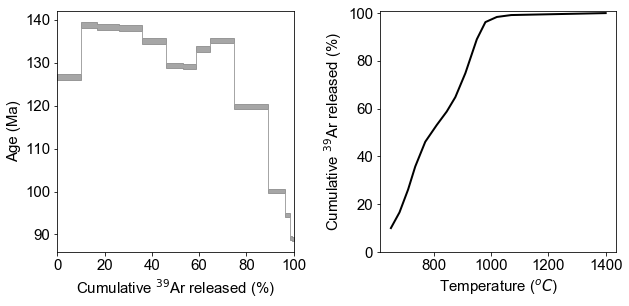

In [457]:
y = np.insert(x, 0, 0)
age_plot = np.insert(data, 0, data[0])
age_plot_err = np.insert(err, 0, err[0])


fig, ax = plt.subplots(1,2, figsize = (9, 4.5))

ax[0].fill_between(y, age_plot - age_plot_err, age_plot + age_plot_err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(y.min(), y.max())

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')

ax[1].plot(temp1,x, lw = 2, 
          color= 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 101)
plt.tight_layout()

In [458]:
data_f = x/100
tempk = temp1 + 273.15
t_obs = time1 * 60
N = data.shape[0]
R = 8.314e-3
age_err = shared(err*2)

In [477]:
Q = pm.Model()

with Q: 
    
    # Volume Term
    phi = pm.Dirichlet('phi', 
                      a = np.ones_like([0.25, 0.75]),
                      shape = 2, 
                      testval = (0.25, 0.75))
    

    
    p1 = phi[0]
    p2 = phi[1]
    
    
    w1_potential = pm.Potential('p1_con', 
                               tt.switch(p1 < 0.2, 
                                        -np.inf, 0) + 
                               tt.switch(p1 > 0.3, 
                                        -np.inf, 0))
    
    
    # Diffusion kinetics 
########################################################  
########################################################
    
    # Activation Energy
    ea1 = pm.Normal('ea1', mu = 196,
                    sd = 3, 
                   testval = 196)
    ea2 = pm.Normal('ea2', mu = 196,
                    sd = 3, 
                   testval = 196)
    
    
    # Frequency Factor
    d01 = pm.Lognormal('d01', mu = 0.002,
                       sd = 0.1)
    
    d02 = pm.Lognormal('d02', mu = 0.002,
                      sd = 0.1)
    
########################################################
########################################################
    
    # Grain sizes
    a1 = pm.Uniform('a1', lower = 0.008, 
                   upper= 0.0125)
    
    a2 = pm.Uniform('a2', lower = 0.008, 
                   upper= 0.0125)


In [478]:
with Q: 
    # Age of each component 
    
    age1 = pm.Uniform('age1', 
                      lower = 0.0, 
                      upper = 4600, 
                     testval = 100)
    
    age2 = pm.Uniform('age2', 
                      lower = 0.0,
                      upper = 4600, 
                     testval = 200)
    
    age_order = pm.Potential('age_order', 
                            tt.switch(age2 - age1 < 0, 
                                     -np.inf, 0))


In [461]:
with Q: 
    # Constructing the multicomponent age model
    w1 = p1
    w2 = p2
    
    X = Increment(ea1, d01, a1, tempk, t_obs)
    Y = Increment(ea2, d02, a2, tempk, t_obs)

    mu2 = ((w1*X)/(w1*X + w2*Y))*age1 \
    + ((w2*Y)/(w1*X + w2*Y))*age2
    
    model2 = pm.Deterministic('model2', mu2)

In [462]:
with Q: 
    # Cumulative Release Model 

    A = fracrelx(ea1, d01, a1, tempk, t_obs)
    B = fracrelx(ea2, d02, a2, tempk, t_obs)
    
    mu1 = w1*A + w2*B

    # MONOTONIC Constraint
######################################################################
    for i in range(len(tempk) -1): 
        F_con1 = pm.Potential(f'F_con1{i}', 
                             tt.switch(A[i + 1] - A[i] <0, 
                                      -np.inf, 0) + 
                             tt.switch(B[i +1] - B[i] < 0, 
                                      -np.inf, 0))

    for i in range(len(tempk) -1): 
        F_con2 = pm.Potential(f'F_con2{i}', 
                             tt.switch(mu1[i + 1] - mu1[i] <0, 
                                      -np.inf, 0))
        
    # Constraint to the fractional release model 
    frac_rel_cons = pm.Potential('frac_rel_cons', 
                                tt.switch(mu1 >1, -np.inf, 0))
######################################################################    

    
    # Fractional Release Equation 
    f_err1 = pm.HalfNormal('f_err1', 
                               sd = 0.025, 
                          shape = N)

In [463]:
# Models for plotting 
with Q: 
    f_model = pm.Deterministic('f_model', 
                               mu1)
    age_model = pm.Deterministic('Age_Model', 
                                mu2)

In [464]:
with Q: 
    age_error_m = pm.HalfNormal('age_error_m', 
                            sd = 5, shape = N)

In [465]:
with Q: 
    # Cumulative Release Likelihood 
    L1 = pm.Normal('L1', mu = mu1, 
                   sd = f_err1, 
                   observed = data_f)
    
    L2 = Sum_of_Squares('L2', mu2, age_error_m, 
                        observed = data)


# Check for the logp of each parameter


In [466]:
Q.check_test_point()

L1                    -1458.61
L2                    -1425.41
a1_interval__            -1.39
a2_interval__            -1.39
age1_interval__          -3.85
age2_interval__          -3.18
age_error_m_log__       -10.78
d01_log__                 0.98
d02_log__                 0.98
ea1                      -2.53
ea2                      -2.53
f_err1_log__            -10.78
phi_stickbreaking__      -1.67
Name: Log-probability of test_point, dtype: float64

In [467]:
SAMPLES = 20000
BURN = 55200
with Q: 
    step1 = pm.Metropolis([a1, a2, 
                     age1, age2, 
                          ea1, ea2, 
                     d01, d02, f_err1])
    
    step2 = pm.NUTS([phi], 
                   target_accept= 0.92, 
                   max_treedepth = 18)

    

    trace = pm.sample(SAMPLES, 
                      tune = BURN, 
                     step = [step1, step2], 
                     cores = 4)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [f_err1]
>>Metropolis: [d02]
>>Metropolis: [d01]
>>Metropolis: [ea2]
>>Metropolis: [ea1]
>>Metropolis: [age2]
>>Metropolis: [age1]
>>Metropolis: [a2]
>>Metropolis: [a1]
>NUTS: [phi]
>NUTS: [age_error_m]
Sampling 4 chains: 100%|██████████| 300800/300800 [1:38:50<00:00, 50.72draws/s]  
There were 3578 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8327177393836466, but should be close to 0.92. Try to increase the number of tuning steps.
There were 588 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3919 divergences after tuning. Increase `target_accept` or reparameterize.
There were 452 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3997 divergences after tuning. Increase `target_accept` or reparameterize.
There were 161 divergences after tuning. Increase 

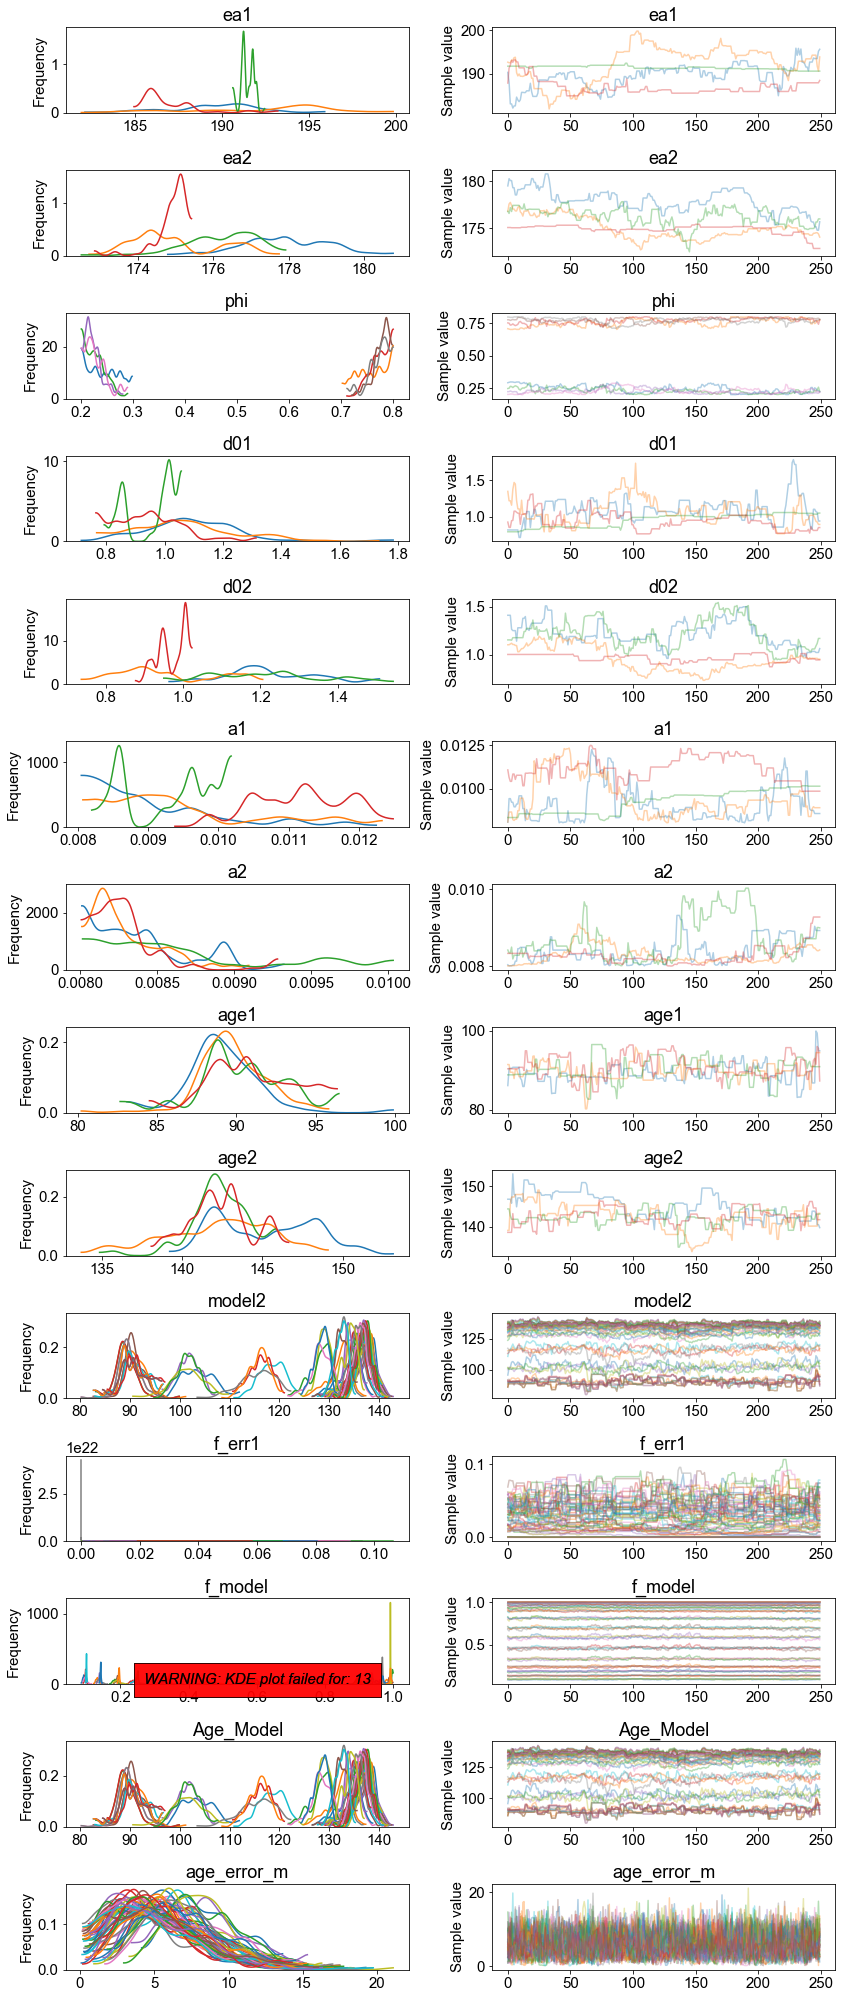

In [479]:
pm.traceplot(trace[-250:]); 

# Post Posterior Predictions


In [469]:
with Q: 
    ppc = pm.sample_ppc(trace, 10000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  
100%|██████████| 10000/10000 [05:44<00:00, 29.00it/s]


# Posterior Predictive model and 95% Credible Intervals

In [470]:
x1 = ppc['L1'].mean(axis = 0)
x2 = ppc['L2'].mean(axis = 0)

# Cumulative Release Model and Data

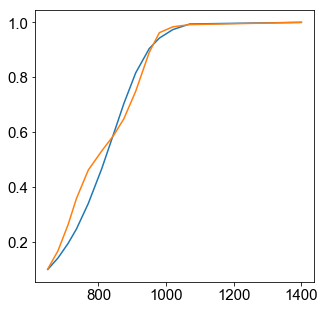

In [471]:
plt.figure(figsize = (5,5))
plt.plot(temp1, x1)
plt.plot(temp1, data_f)

# Age Spectra Model and Data

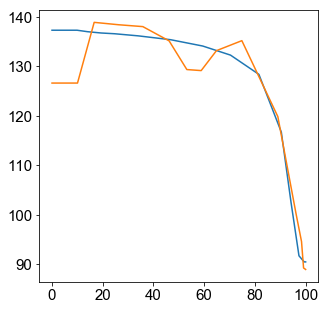

In [472]:
x2 = trace['Age_Model'][-SAMPLES:].mean(axis = 0)

x1_plot = np.insert(x1, 0, 0)
x2_plot = np.insert(x2, 0, x2[0])
plt.figure(figsize = (5,5))
plt.plot(100*x1_plot, x2_plot)
plt.plot(y, age_plot)

In [473]:
# 95% Credible model intervals 
low_age, high_age = np.percentile(trace['Age_Model'][-SAMPLES:],
                                  [2.5, 97.5], 
                                  axis=0)
low_f, high_f = np.percentile(trace['f_model'][-SAMPLES:], 
                             [2.5, 97.5], 
                             axis = 0)

low_age_plot = np.insert(low_age, 0, low_age[0])
high_age_plot = np.insert(high_age, 0, high_age[0])

# Final Plot

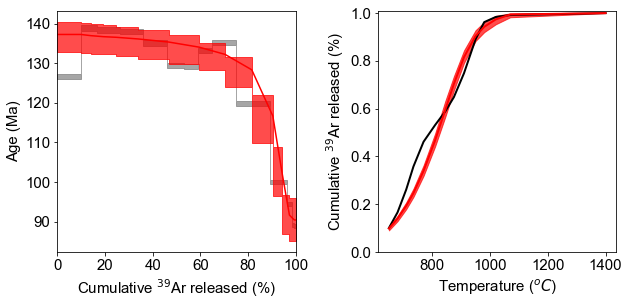

In [474]:
y = np.insert(x, 0, 0)
age_plot = np.insert(data, 0, data[0])
age_plot_err = np.insert(err, 0, err[0])


fig, ax = plt.subplots(1,2, figsize = (9, 4.5))
# Age
ax[0].fill_between(y, age_plot - age_plot_err, age_plot + age_plot_err, 
                  step = 'pre', 
                  color = 'grey', alpha = 0.7, 
                  edgecolor = 'k')
ax[0].set_xlim(y.min(), y.max())


ax[0].plot(100*x1_plot, x2_plot, 'r-')
ax[0].fill_between(100*x1_plot, low_age_plot, 
                   high_age_plot,
                  step = 'pre', 
                  color = 'r', alpha = 0.7, 
                  edgecolor = 'k')

ax[0].set_ylabel('Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar released (%)')


# Cumulative Release

ax[1].plot(temp1,x/100, lw = 2, 
          color= 'k')
ax[1].plot(temp1,x1, lw = 2, 
          color= 'r')
ax[1].fill_between(temp1, low_f, 
                   high_f,
                  color = 'r', alpha = 0.7, 
                  edgecolor = 'k')
ax[1].set_ylabel('Cumulative $^{39}$Ar released (%)')
ax[1].set_xlabel('Temperature ($^{o}C$)')
ax[1].set_ylim(0, 1.01)
plt.tight_layout()

In [475]:
print(trace['age1'][-20000:].mean(axis =0))
print(trace['age2'][-20000:].mean(axis =0))

90.44184708171052
143.00518922376455


In [476]:

print(2*np.std(trace['age1'][-20000:]))
print(2*np.std(trace['age2'][-20000:]))

5.524049691491043
5.316992923893042


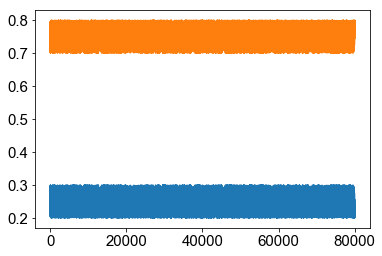

In [425]:
plt.plot(trace['phi']); 

In [392]:
df = pd.DataFrame({"age_model": x2,
                   "age_model_low":low_age, 
                   "age_model_high":high_age, 
                  "frel_model": x1, 
                   "frel_model_low": low_f, 
                   "frel_model_high":high_f, 
                   "age_data": data, 
                   "age_err": err,
                   "frel_data":x/100, 
                   "temp":temp1
                  })

In [393]:
df.to_csv("Kula_biotite_1_posterior.csv")

In [315]:
df2 = pm.trace_to_dataframe(trace[-SAMPLES::5])
df2.to_csv("Kula_biotite_1_trace.csv")